# Machine Learning Basics

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Alan Turing:</strong> We are not interested in the fact that the brain has the consistency of cold porridge.
</div>

<iframe class="speakerdeck-iframe" frameborder="0" src="https://speakerdeck.com/player/db5df387845c4802b0bbae449095899c" title="Machine Learning for Materials (Lecture 2)" allowfullscreen="true" style="border: 0px; background-clip: padding-box; background-color: rgba(0, 0, 0, 0.1); margin: 0px; padding: 0px; border-radius: 6px; box-shadow: rgba(0, 0, 0, 0.2) 0px 5px 40px; width: 50%; height: auto; aspect-ratio: 560 / 420;" data-ratio="1.3333333333333333"></iframe>

[Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture2-modelling)

## 💎 Crystal hardness

Are you excited to tackle a regression problem? Our goal is to learn:

- How to load and featurise materials datasets using *matminer*
- How to train and evaluate regression models with *scikit-learn*
- How to interpret model predictions and feature importance

Today's dataset consists of the [bulk modulus](https://en.wikipedia.org/wiki/Bulk_modulus) for more than 10,000 inorganic crystals. The exercise aims to build your understanding of how to approach supervised learning problems.

The energy of a crystal varies with the volume of the unit cell. The equilibrium volume is found at the minimum in the potential energy surface. The shape of this curve can be described by an equation of state, where energy is a function of volume or pressure, i.e. $E(V)$ or $E(P)$. The curvature is related to the bulk modulus $B$, which can be defined as:

$
B = -V \frac{\partial P}{\partial V} = V \frac{\partial^2 E}{\partial V^2}
$

The typical unit of $B$ is GPa. For example, diamond has has a measured bulk modulus of $B$ = 443 GPa at T = 4 K. The bulk modulus is a useful quantity in models of materials bonding, thermodynamics, and mechanics. For instance, the inverse of the bulk modulus is the compressability of a crystal ($\kappa = \frac{1}{B}$).

We will use the Python package `matminer` (https://matminer.readthedocs.io) to access the materials dataset and featurise the data in a form that is suitable for statistical analysis and building machine learning models. We will use the computational materials science package `pymatgen` (https://pymatgen.org) that powers the [Materials Project](https://materialsproject.org). There are many new concepts that will be explored in future lectures, so don't worry about grasping everything now.

In [10]:
# Installation of libraries
!pip install matminer --quiet
!pip install seaborn --quiet

In [11]:
!pip show numpy # Check version of numpy

Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRI

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>🍧 Tip:</strong> The import block grows large as you use more Python libraries. You can look up each package (try a web search to find documentation and examples) to learn more about the modules we are using.
</div>

In [12]:
# Basic utilities
import pprint  # Pretty print data structures
import warnings  # Warning control
import numpy as np # Numerical operations
from numpy.exceptions import ComplexWarning  # Warning for complex numbers

# Data handling
import pandas as pd  # Data manipulation with DataFrames
from monty.serialization import loadfn  # Load serialised data

# Materials science
from pymatgen.core import Structure  # Materials analysis for crystal structures
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets

# Visualisation
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualisation
plt.style.use('ggplot')  # Set Matplotlib style to 'ggplot'

# Warning management
warnings.filterwarnings("ignore", category=ComplexWarning)  # Ignore ComplexWarning

# Performance adjustments
teaching_mode = True  # To make models run faster

<details>
<summary>Colab error solution</summary>
If running the import module cell fails with an "AttributeError", click `Runtime` -> `Restart Session` and then simply rerun the cell.
</details>

## Bulk moduli dataset

From `matminer`, we can check what datasets are available using the `datasets.get_available_datasets()` method.

In [13]:
# Print the available datasets
matminer.datasets.get_available_datasets(print_format='low')

['boltztrap_mp',
 'brgoch_superhard_training',
 'castelli_perovskites',
 'citrine_thermal_conductivity',
 'dielectric_constant',
 'double_perovskites_gap',
 'double_perovskites_gap_lumo',
 'elastic_tensor_2015',
 'expt_formation_enthalpy',
 'expt_formation_enthalpy_kingsbury',
 'expt_gap',
 'expt_gap_kingsbury',
 'flla',
 'glass_binary',
 'glass_binary_v2',
 'glass_ternary_hipt',
 'glass_ternary_landolt',
 'heusler_magnetic',
 'jarvis_dft_2d',
 'jarvis_dft_3d',
 'jarvis_ml_dft_training',
 'm2ax',
 'matbench_dielectric',
 'matbench_expt_gap',
 'matbench_expt_is_metal',
 'matbench_glass',
 'matbench_jdft2d',
 'matbench_log_gvrh',
 'matbench_log_kvrh',
 'matbench_mp_e_form',
 'matbench_mp_gap',
 'matbench_mp_is_metal',
 'matbench_perovskites',
 'matbench_phonons',
 'matbench_steels',
 'mp_all_20181018',
 'mp_nostruct_20181018',
 'phonon_dielectric_mp',
 'piezoelectric_tensor',
 'ricci_boltztrap_mp_tabular',
 'steel_strength',
 'superconductivity2018',
 'tholander_nitrides',
 'ucsb_thermoe

We can use the `get_all_dataset_info` function from the `matminer.datasets.dataset_retrieval` module to output a detailed description of a matminer dataset. Let's check the information for the `matbench_log_kvrh` dataset.

Here "K" relates to the bulk modulus (which we called $B$), and "VRH" relates to the Voigt-Reuss-Hill equation of state, which is one approach to define a value for each material.

In [14]:
print(matminer.datasets.dataset_retrieval.get_all_dataset_info('matbench_log_kvrh'))

Dataset: matbench_log_kvrh
Description: Matbench v0.1 test dataset for predicting DFT log10 VRH-average bulk modulus from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having negative G_Voigt, G_Reuss, G_VRH, K_Voigt, K_Reuss, or K_VRH and those failing G_Reuss <= G_VRH <= G_Voigt or K_Reuss <= K_VRH <= K_Voigt and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	log10(K_VRH): Target variable. Base 10 logarithm of the DFT Voigt-Reuss-Hill average bulk moduli in GPa.
	structure: Pymatgen Structure of the material.
Num Entries: 10987
Reference: Jong, M. De, Chen, W., Angsten, T., Jain, A., Notestine, R., Gamst,
A., Sluiter, M., Ande, C. K., Zwaag, S. Van Der, Plata, J. J., Toher,
C., Curtarol

We can then load a dataset using the `load_dataset` method.

In [15]:
# Use matminer to download the dataset
df = load_dataset('matbench_log_kvrh')
print(f'The full dataset contains {df.shape[0]} entries. \n')

if teaching_mode:
  # Store the original DataFrame as a copy
  full_dataset_df = df.copy()
  # Create a subset of the original DataFrame for demonstration purposes
  df = df.sample(n=1500, random_state=41)
  print(f'For teaching purposes we will only work with {df.shape[0]} entries from the DataFrame to make the model training and testing faster. \n')

print('The DataFrame is shown below:')
df.head(10)

The full dataset contains 10987 entries. 

For teaching purposes we will only work with 1500 entries from the DataFrame to make the model training and testing faster. 

The DataFrame is shown below:


,structure,log10(K_VRH)
3013,"[[1.5733895 1.5733895 1.5733895] Ti, [0. 0. 0....",2.060698
7030,"[[0. 2.48703496 2.48703496] Na, [2.487...",0.301030
8743,"[[4.80865721 4.80865721 4.80865721] Zr, [3.205...",2.071882
4050,"[[0. 0. 1.83652429] P, [3.1335...",2.344392
6792,"[[2.3309339 1.34576271 7.92190123] Pb, [-2.33...",0.602060
1755,"[[-0.13114877 2.07420334 -0.52208471] Zr, [ 2...",1.903090
1470,"[[5.73166765 5.73166765 5.73166765] Ca, [1.910...",1.612784
2300,"[[ 0. 0. 17.49196778] Cu, [-2...",1.000000
1337,"[[1.510518 3.56803694 7.81362377] Bi, [1.510...",1.763428
10451,"[[0. 0. 0.] Nd, [-2.82958438e-06 3.26347501e+...",2.230449


### Visualise the target variable

We can use `df.describe()` to produce summary statistics of the numerical columns. The importance of this is to check whether the data for our target variable, `log10(K_VRH)`, is reasonable. Negative values for the bulk modulus are considered unphysical and forbidden by crystal thermodynamics. You can think about why from the definition.

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>Why 🪵?</strong> Due to the large spread in `K_VRH` values, `log₁₀(K_VRH)` is used to reduce skewness and stabilise variance, making analysis and regression models more effective.
</div>

As we are working with `log10` of the bulk modulus, it should not be possible to have negative values in our target variable column as the logarithm of a negative number is undefined. This also gives us a quick check for the input data.

In [16]:
df.describe()

,log10(K_VRH)
count,1500.000000
mean,1.858558
std,0.394244
min,0.000000
25%,1.633468
50%,1.916446
75%,2.152288
max,2.610660


From the summary statistics, the minimum value for `log10(K_VRH)` is zero, so it appears that there are no glaring issues with the target variable.  

For a better understanding, let's make a histogram to visualise the distribution. This is best practice when you encounter any new dataset.

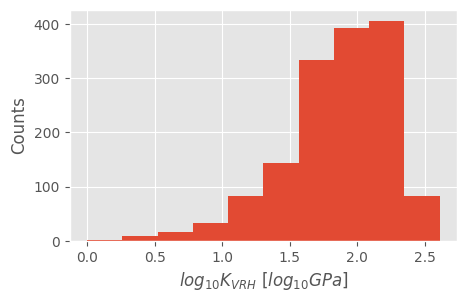

In [17]:
import matplotlib.pyplot as plt

# Plot a histogram
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(df['log10(K_VRH)'])
ax.set_xlabel(r'$log_{10}K_{VRH}$ [$log_{10}GPa$]')
ax.set_ylabel('Counts')
plt.show()

<details>
<summary> Code hint </summary>
Your dataframe is not called df22!
</details>

## Features of materials
As you may notice from the dataset, we only have one input feature, the crystal structure. This is not a numerical feature that we can use for a regression model. For supervised machine learning, we must represent each material by a vector that can be used as an input to the model, e.g.

$$f(\textrm{material}) \rightarrow [1.1,0.8,3.5,0.01]$$

would be a four-dimensional representation.
For now we will use some pre-selected features from `matminer` for this regression task. Materials representations will be covered in Lecture 4.

### Composition-based features

To use the `ElementProperty` featuriser, we first need to add a `pymatgen.core.composition.Composition` object to our DataFrame. There are several ways to do this but we will proceed using the `composition` property of the pymatgen `Structure` class.

In [18]:
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures

# Add a composition column to df using the composition property of the Structure class and a lambda function
df['composition'] = df.structure.apply(lambda x: x.composition )
df.head()

,structure,log10(K_VRH),composition
3013,"[[1.5733895 1.5733895 1.5733895] Ti, [0. 0. 0....",2.060698,"(Ti, Zn)"
7030,"[[0. 2.48703496 2.48703496] Na, [2.487...",0.301030,"(Na, Tl)"
8743,"[[4.80865721 4.80865721 4.80865721] Zr, [3.205...",2.071882,"(Zr, Cu, Hg)"
4050,"[[0. 0. 1.83652429] P, [3.1335...",2.344392,"(P, Ti, Ru)"
6792,"[[2.3309339 1.34576271 7.92190123] Pb, [-2.33...",0.602060,"(Pb, I)"


The new composition column contains both the elements and the amount of each element in the composition. Let's use the `ElementProperty` featuriser to add some composition-based features to our dataset.

In [19]:
# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however this has been known to slow performance on some systems, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Apply the ElementProperty featuriser
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition')

# Print the shape of the DataFrame
print(df.shape)
df.head()

/usr/local/lib/python3.12/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/1500 [00:00<?, ?it/s]

(1500, 135)


,structure,log10(K_VRH),composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
3013,"[[1.5733895 1.5733895 1.5733895] Ti, [0. 0. 0....",2.060698,"(Ti, Zn)",22.0,30.0,8.0,26.000000,4.000000,22.0,43.0,...,0.000023,0.000011,0.000011,0.0,194.0,194.0,0.0,194.000000,0.000000,194.0
7030,"[[0. 2.48703496 2.48703496] Na, [2.487...",0.301030,"(Na, Tl)",11.0,81.0,70.0,28.500000,26.250000,11.0,2.0,...,0.000000,0.000000,0.000000,0.0,194.0,229.0,35.0,220.250000,13.125000,229.0
8743,"[[4.80865721 4.80865721 4.80865721] Zr, [3.205...",2.071882,"(Zr, Cu, Hg)",29.0,80.0,51.0,44.500000,17.750000,29.0,44.0,...,0.000000,0.000000,0.000000,0.0,166.0,225.0,59.0,202.500000,22.500000,225.0
4050,"[[0. 0. 1.83652429] P, [3.1335...",2.344392,"(P, Ti, Ru)",15.0,44.0,29.0,27.000000,11.333333,15.0,43.0,...,0.000023,0.000008,0.000010,0.0,2.0,194.0,192.0,130.000000,85.333333,2.0
6792,"[[2.3309339 1.34576271 7.92190123] Pb, [-2.33...",0.602060,"(Pb, I)",53.0,82.0,29.0,62.666667,12.888889,53.0,81.0,...,0.000000,0.000000,0.000000,0.0,64.0,225.0,161.0,117.666667,71.555556,64.0


There are now a lot more columns in the DataFrame. We can check the reference for a property featuriser using the `.citations()` method as shown below.

In [20]:
el_prop_featuriser.citations()

['@article{ward_agrawal_choudary_wolverton_2016, title={A general-purpose machine learning framework for predicting properties of inorganic materials}, volume={2}, DOI={10.1038/npjcompumats.2017.28}, number={1}, journal={npj Computational Materials}, author={Ward, Logan and Agrawal, Ankit and Choudhary, Alok and Wolverton, Christopher}, year={2016}}']

### Structure-based features

Within `matminer`, there are many featurisers which operate on crystal structures. We will add some simple features based on the density of the structures using `DensityFeatures`. We will return to these later in the module.

In [21]:
# Crystal structure to vector
density_featuriser = DensityFeatures()
density_featuriser.set_n_jobs(1)
df=density_featuriser.fit_featurize_dataframe(df, col_id='structure')

df.head()

DensityFeatures:   0%|          | 0/1500 [00:00<?, ?it/s]

,structure,log10(K_VRH),composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
3013,"[[1.5733895 1.5733895 1.5733895] Ti, [0. 0. 0....",2.060698,"(Ti, Zn)",22.0,30.0,8.0,26.000000,4.000000,22.0,43.0,...,0.0,194.0,194.0,0.0,194.000000,0.000000,194.0,6.036543,15.580046,0.699614
7030,"[[0. 2.48703496 2.48703496] Na, [2.487...",0.301030,"(Na, Tl)",11.0,81.0,70.0,28.500000,26.250000,11.0,2.0,...,0.0,194.0,229.0,35.0,220.250000,13.125000,229.0,3.688344,30.766697,0.828964
8743,"[[4.80865721 4.80865721 4.80865721] Zr, [3.205...",2.071882,"(Zr, Cu, Hg)",29.0,80.0,51.0,44.500000,17.750000,29.0,44.0,...,0.0,166.0,225.0,59.0,202.500000,22.500000,225.0,10.556981,16.472744,0.764106
4050,"[[0. 0. 1.83652429] P, [3.1335...",2.344392,"(P, Ti, Ru)",15.0,44.0,29.0,27.000000,11.333333,15.0,43.0,...,0.0,2.0,194.0,192.0,130.000000,85.333333,2.0,7.173677,13.881716,0.597563
6792,"[[2.3309339 1.34576271 7.92190123] Pb, [-2.33...",0.602060,"(Pb, I)",53.0,82.0,29.0,62.666667,12.888889,53.0,81.0,...,0.0,64.0,225.0,161.0,117.666667,71.555556,64.0,5.134592,49.697122,0.318041


## Bulk modulus regression

With regression tasks, we want to fit a model that maps our input feature $x$ to our target variable $y$, i.e. $y=f(x)$. Here, $x$ and $y$ are vectors of dimensions $M$ and $N$, respectively, such that $f: \mathbb{R}^M\rightarrow\mathbb{R}^N$.  

Supervised machine learning problems generally take the following form:
* Select a form for the model $f$
* Determine an error/loss function that is used to evaluate model performance
* Optimise the parameters of the model to minimise the error

The error, $L(\hat{y},y)$, is a function of the predicted target variable $\hat{\textbf{y}}=f(\textbf{x})$ and the true target variable, $\textbf{y}$. We want our model to minimise $L$.

For our problem. the target variable is `log(K_VRH)`, which we want to predict from knowledge of the composition and structure (represented by the set of chosen features).

We can make extensive use of [scikit-learn](https://scikit-learn.org) for these tasks.

### Data preparation

To start, we need to split our dataset into the target variable `log10(K_VRH)` and the input features. For the input features, we must remove any non-numerical data.

In [22]:
# Define the features we want to keep
features_to_drop = ['structure','composition','log10(K_VRH)']
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Get an array of the features
X = df[feature_cols].values

# Get an array of the target variable
y = df['log10(K_VRH)'].values

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (1500, 135)
Shape of y: (1500,)


We can also check the names of the features used for our model.


In [24]:
print(f'We have {len(feature_cols)} features in our dataset.')
print(feature_cols)

We have 135 features in our dataset.
['MagpieData minimum Number', 'MagpieData maximum Number', 'MagpieData range Number', 'MagpieData mean Number', 'MagpieData avg_dev Number', 'MagpieData mode Number', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum MendeleevNumber', 'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mode MendeleevNumber', 'MagpieData minimum AtomicWeight', 'MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev AtomicWeight', 'MagpieData mode AtomicWeight', 'MagpieData minimum MeltingT', 'MagpieData maximum MeltingT', 'MagpieData range MeltingT', 'MagpieData mean MeltingT', 'MagpieData avg_dev MeltingT', 'MagpieData mode MeltingT', 'MagpieData minimum Column', 'MagpieData maximum Column', 'MagpieData range Column', 'MagpieData mean Column', 'MagpieData avg_dev Column', 'MagpieData mode Column', 'MagpieData minimum Row', 'Mag

<details>
<summary> Code hint </summary>
Check your print statement!
</details>

### Baseline linear regression model
A simple model is the linear regressor.  For a univariate linear regressor represented by $\hat{y}=mx+c$, the task is to find the best value of $m$ and $c$ that minimise the model error.

If we were to consider multivariate linear regression, then our equation transforms to $\hat{y}=\beta_0 + ∑_1^n\beta_ix_i$, where $\beta_i$ are the weights of the model and $x_i$ are the input features.

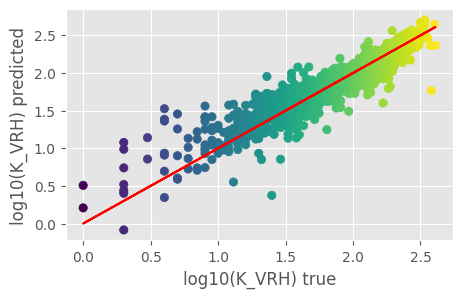

In [25]:
# Import linear regression model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit the model to the data
lr = LinearRegression()
lr.fit(X, y)

def make_prediction_plot(X, y, model, label):
    """
    Plot and return predictions for the given model and data.

    Parameters:
    X : Input features.
    y : Actual target values.
    model : Fitted model.
    label : Descriptor for the axes labels.

    Returns:
    Predicted values.
    """
    y_pred = model.predict(X)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} true')
    ax.set_ylabel(f'{label} predicted')
    plt.show()

    return y_pred

# Make predictions using the fitted model
y_pred = make_prediction_plot(X, y, lr, 'log10(K_VRH)')

In [26]:
from sklearn import metrics

# Mean absolute error
print (f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')

# Mean squared error
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')

# $r^2$ - coefficient of determination
print(f'The training r^2 = {lr.score(X,y):.3f}')

The training MAE = 0.099 log10GPa
The training RMSE = 0.148 log10GPa
The training r^2 = 0.860


How does this model perform? Linear regression assumes additive, independent relationships between features and the target. This approach may be too simplistic for complex materials behaviour.

### Random forest regressor

We can do better with a non-linear model. Let's try a machine learning regressor. [Random forest](https://en.wikipedia.org/wiki/Random_forest) is an ensemble machine learning algorithm that combines multiple [decision trees](https://en.wikipedia.org/wiki/Decision_tree) to improve predictive accuracy.

Random forest can be applied to both classification and regression tasks. The prediction is made by taking a majority vote (for classification) or averaging (for regression) of the predictions from individual trees. Mathematically, it can be represented as:

$
\hat{y}_{RF} = \frac{1}{n_{trees}} \sum_{i=1}^{n_{trees}} f_i(x)
$

where:
- $\hat{y}_{RF}$ is the random forest prediction.
- $n_{trees}$ is the number of decision trees in the forest.
- $f_i(x)$ represents the prediction of the $i$-th tree.

#### 1. Create the regressor

In `sklearn`, the random forest regressor is created by:

```python
RandomForestRegressor(n_estimators=<int>, criterion=<str>, max_depth=<int>, min_samples_split=<int>, min_samples_leaf=<int>)
```

The hyperparameters that need to be set are:
* `n_estimators`: number of decision trees in the random forest model.
* `criterion`: loss function to be minimised. Default value is 'squared_error` which is the MSE.
* `max_depth`: maximum depth of the tree.
* `min_sample_split`: minimum number of samples required to split an internal node.
* `min_samples_leaf`: minimum number of samples required to be at a leaf node.

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=100,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model
rf.fit(X,y)

RandomForestRegressor(random_state=42)

<details>
<summary> Why is the random state set to 42?</summary>
Most random number generators start with an initial seed value and then produces a sequence of numbers that appears random. Since the algorithms are deterministic, providing the same seed will result in the same sequence of "random" numbers. 42 is simply a science fiction reference.
</details>

We have now trained our first non-linear ML model 🎉.  

We can now make predictions and plot the results. We will use the plotting function `make_prediction_plot()` that we defined earlier to make the plots.

Linear regression


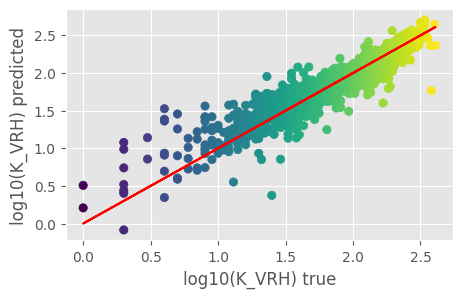

Random Forest model


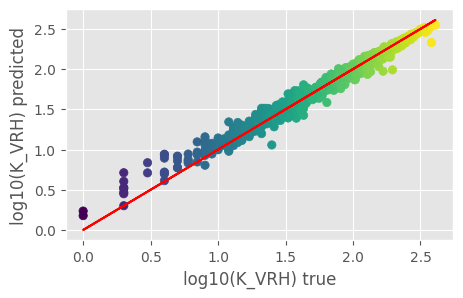

In [28]:
print("Linear regression")
y_pred_lr = make_prediction_plot(X,y,lr,'log10(K_VRH)')

print("Random Forest model")
y_pred = make_prediction_plot(X,y,rf,'log10(K_VRH)')

Now let's quantify the performance of the random forest model:

In [29]:
# Print the metrics
print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')
print(f'The training r^2 = {rf.score(X,y):.3f}')

The training MAE = 0.035 log10GPa
The training RMSE = 0.056 log10GPa
The training r^2 = 0.980


The coefficient of determination, $r^2$, as well as the low RMSE suggest that this model is performs well. However, it is also likely that the model is simply overfitted to reproduce the training data. This means that it will not generalise to other materials (unseen data), which is necessary for a meaningful machine learning model.

Training performance alone is not enough! We use cross-validation to check generalisability.

#### 2. Cross validation
To better determine the quality of our model, we can peform cross-validation (CV). CV enables us to evaluate the out-of-sample goodness-of-fit of a regressor. We will use $k$-fold CV, which splits the training set into $k$ subsets. Each subset is used as a validation set to evaluate the performance, with the model being trained on the remaining $k-1$ subsets. Don't worry, we'll cover this in later lectures.

Let's perform 5-fold CV:

In [30]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

# Define the number of splits for cross-validation
n_splits = 5 if teaching_mode else 10

# Compute the cross-validation score
cv = KFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42
    )

scores= cross_val_score(rf, X, y,cv=cv, scoring='neg_mean_absolute_error')

r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')

print('From our cross-validation, we have obtained the following results:')
print(f'mean MAE = {np.mean(np.abs(scores)):.3f} log10GPa')
print(f'mean r^2 = {np.mean(np.abs(r2_scores)):.3f}')

From our cross-validation, we have obtained the following results:
mean MAE = 0.096 log10GPa
mean r^2 = 0.849


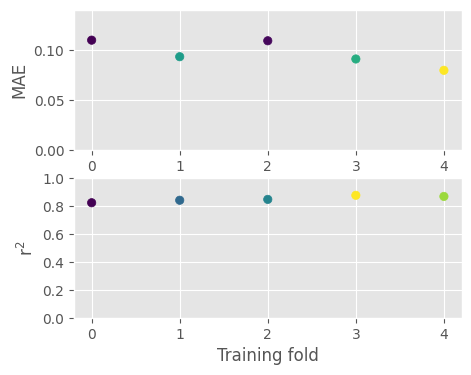

In [31]:
# Show the training scores for each k-fold
fig, ax = plt.subplots(2, 1, figsize=(5, 4))

ax[0].scatter([i for i in range(len(scores))], np.abs(scores), c=scores, cmap='viridis')
ax[1].scatter([i for i in range(len(r2_scores))], np.abs(r2_scores), c=r2_scores, cmap='viridis')
ax[0].set_xlabel('Training fold')
ax[0].set_ylabel('MAE')
ax[0].set_ylim(0, 0.14)
ax[0].set_xticks(range(len(scores)))
ax[1].set_xticks(range(len(r2_scores)))
ax[1].set_xlabel('Training fold')
ax[1].set_ylabel('r$^2$')
ax[1].set_ylim(0, 1.0)

# Display the plot
plt.show()

There is an increase in the error (decrease in performance) for the CV model. However, the MAE is still reasonable. Let's visualise the result of the final model:

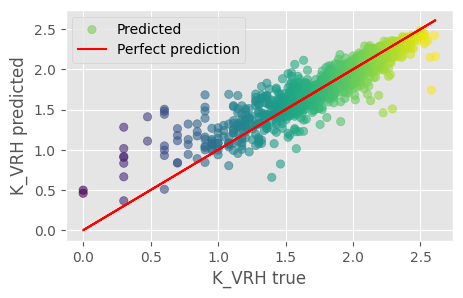

In [32]:
from sklearn.model_selection import cross_val_predict

# Plot the original and predicted data against each other
fig, ax = plt.subplots(figsize=(5, 3))

# Scatter plot with color
ax.scatter(y, cross_val_predict(rf, X, y, cv=cv), c=y, cmap='viridis', label='Predicted', alpha=0.6)

# Red line representing a perfect prediction (y = x)
ax.plot(y, y, 'r-', label='Perfect prediction')

# Set labels and legend
ax.set_xlabel('K_VRH true')
ax.set_ylabel('K_VRH predicted')
ax.legend()

plt.show()

## Feature importance

We fed in many materials features, but which were most useful? Understanding this will increase our understanding (the interpretability) of the model.

We can see how particular features contribute to a Random Forest model by looking at the `RandomForestRegressor().feature_importances_` attribute. Some features are significant, whereas others offer very little contribution.

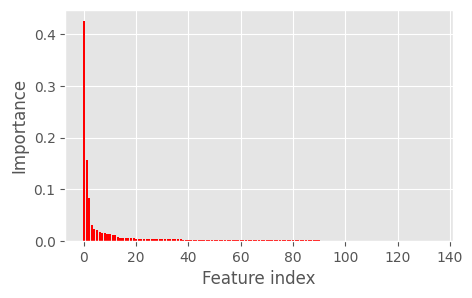

In [33]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices that would sort the importances array from largest to smallest
indices = np.argsort(importances)[::-1]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the feature importance
ax.bar(range(X.shape[1]), importances[indices], color="r", align="center")

# Set the labels
ax.set_xlabel("Feature index")
ax.set_ylabel("Importance")

plt.show()

There is a rapid drop off in the feature importance, with few features offering a significant contribution to the model.

Below we will only plot the importance for the top-$N$ features. Try visualising the top 5 features—volume per atom (‘vpa’) often ranks highly.

/tmp/ipython-input-1811413568.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')


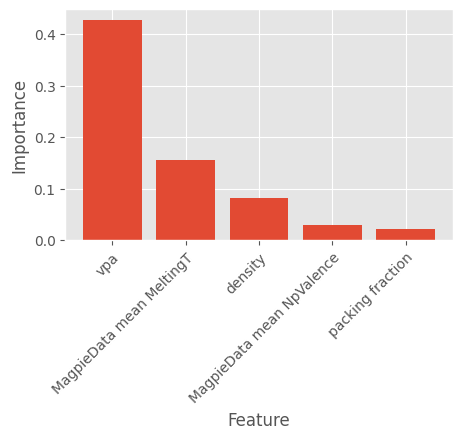

Top 5 Features:
    1. vpa (0.427)
    2. MagpieData mean MeltingT (0.156)
    3. density (0.083)
    4. MagpieData mean NpValence (0.030)
    5. packing fraction (0.022)


In [35]:
# Visualise the top N features
N = 5

# Get the names of the top N important features
top_feature_names = df[feature_cols].columns.values[np.argsort(importances)[::-1][:N]]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the top N feature importances
ax.bar(x=top_feature_names, height=importances[np.argsort(importances)[::-1][:N]])

# Set the labels and title
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")

# Rotate x-axis labels for better readability
ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

# Print them too
print(f"Top {N} Features:")
for feat in range(N):
    print(f"    {feat+1}. {feature_cols[indices[feat]]} ({importances[indices[feat]]:.3f})")

<details>
<summary> Code hint </summary>
Remember to set N!
</details>

## 🚨 Exercise 2

<div style="background-color: #dceefb; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>💡 Coding exercises:</strong> The exercises are designed to apply what you have learned with room for creativity. It is fine to discuss solutions with your classmates, but the actual code should not be directly copied.
</div>

### Your details

In [37]:
import numpy as np

# Insert your values
Name = "Hanzhi Zhu" # Replace with your name
CID = 2243276 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Hanzhi Zhu [CID: 2243276]


### 🧪 Problem: Feature Selection and Model Interpretation

In machine learning, reducing the number of input features can help to simplify models, reduce overfitting, and improve generalisability.

Tasks will be provided in class.

In [38]:
#Task 1
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

# ----- Task 1: select top 5 by feature_importances_ -----
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]          # descending
top5_idx = indices[:5]
cols_top5 = [feature_cols[i] for i in top5_idx]  # feature names

X_top5 = df[cols_top5].values
y_top5 = df['log10(K_VRH)'].values

print("Top 5 features (by RandomForest feature_importances_):")
for rank, i in enumerate(top5_idx, start=1):
    print(f"{rank}. {feature_cols[i]} (importance = {importances[i]:.4f})")

# ----- CV setup (same as PDF) -----
n_splits = 5 if teaching_mode else 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# ----- helper: evaluate with CV (MAE + R2) -----
def cv_mae_r2(model, X_use, y_use, cv):
    mae_scores = cross_val_score(model, X_use, y_use, cv=cv, scoring='neg_mean_absolute_error')
    r2_scores  = cross_val_score(model, X_use, y_use, cv=cv, scoring='r2')
    mean_mae = np.mean(np.abs(mae_scores))
    mean_r2  = np.mean(np.abs(r2_scores))
    return mean_mae, mean_r2

# ----- Original (all features) CV -----
rf_all = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    random_state=42
)

mae_all, r2_all = cv_mae_r2(rf_all, X, y, cv)

# ----- Top-5 features model CV -----
rf_top5 = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    random_state=42
)

mae_top5, r2_top5 = cv_mae_r2(rf_top5, X_top5, y_top5, cv)

print("\n5-fold CV performance comparison:")
print(f"All features:   mean MAE = {mae_all:.3f} log10GPa, mean r^2 = {r2_all:.3f}")
print(f"Top 5 features: mean MAE = {mae_top5:.3f} log10GPa, mean r^2 = {r2_top5:.3f}")




Top 5 features (by RandomForest feature_importances_):
1. vpa (importance = 0.4267)
2. MagpieData mean MeltingT (importance = 0.1564)
3. density (importance = 0.0828)
4. MagpieData mean NpValence (importance = 0.0297)
5. packing fraction (importance = 0.0219)

5-fold CV performance comparison:
All features:   mean MAE = 0.096 log10GPa, mean r^2 = 0.849
Top 5 features: mean MAE = 0.109 log10GPa, mean r^2 = 0.828


In [43]:
# Task 2
print("=== Task 2: Names of top 5 features ===")
for f in cols_top5:
    print(" -", f)

print(
"Overall, the selected top five features capture complementary aspects of atomic packing "
"(vpa, density, packing fraction), bonding strength (mean melting temperature), and electronic "
"structure (mean p-valence electrons). Their importance is physically reasonable and consistent "
"with materials science intuition for factors controlling bulk modulus. "
"Furthermore, the fact that a model using only these five features achieves performance comparable "
"to the full-feature model suggests that the bulk modulus is largely governed by a small number of "
"physically meaningful descriptors rather than many weakly variables."
)


=== Task 2: Names of top 5 features ===
 - vpa
 - MagpieData mean MeltingT
 - density
 - MagpieData mean NpValence
 - packing fraction
Overall, the selected top five features capture complementary aspects of atomic packing (vpa, density, packing fraction), bonding strength (mean melting temperature), and electronic structure (mean p-valence electrons). Their importance is physically reasonable and consistent with materials science intuition for factors controlling bulk modulus. Furthermore, the fact that a model using only these five features achieves performance comparable to the full-feature model suggests that the bulk modulus is largely governed by a small number of physically meaningful descriptors rather than many weakly informative variables.


In [48]:
# Task 3


import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

# 1) Select the single most important feature
top1_feature = cols_top5[0]
print("Task 3: Single most important feature")
print(top1_feature)

X_top1 = df[[top1_feature]].values
y = df["log10(K_VRH)"].values

# 2) Define Random Forest model (same settings)
rf_top1 = RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    max_depth=None,
    random_state=42
)

# 3) 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_neg = cross_val_score(
    rf_top1, X_top1, y, cv=cv, scoring="neg_mean_absolute_error"
)
r2_scores = cross_val_score(
    rf_top1, X_top1, y, cv=cv, scoring="r2"
)

mae_top1 = np.mean(np.abs(mae_neg))
r2_top1 = np.mean(r2_scores)

print("Task 3: 5-fold CV performance (single feature)")
print(f"MAE = {mae_top1:.4f} log10GPa")
print(f"R^2 = {r2_top1:.4f}")

print(
"Task 3 comment: Using only vpa performs poorly because the cross-validated R^2 is low, "
"meaning the one-feature model explains only a small fraction of the variance in bulk modulus. "
"This suggests that bulk modulus is not determined by packing alone; bonding strength and "
"electronic-structure descriptors are also needed for accurate prediction, so a one-feature model "
"is not very useful in practice in prediction."
)




Task 3: Single most important feature
vpa
Task 3: 5-fold CV performance (single feature)
MAE = 0.2464 log10GPa
R^2 = 0.2873
Task 3 comment: Using only vpa performs poorly because the cross-validated R^2 is low, meaning the one-feature model explains only a small fraction of the variance in bulk modulus. This suggests that bulk modulus is not determined by packing alone; bonding strength and electronic-structure descriptors are also needed for accurate prediction, so a one-feature model is not very useful in practice in prediction.


<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>📓 Submission:</strong> When your notebook is complete in Google Colab, go to <em>File > Download</em> and choose <code>.ipynb</code>. The completed file should be uploaded to Blackboard under assignments for MATE70026.
</div>

## 🌊 Dive deeper

* _Level 1:_ Tackle Chapter 14 on Tree-Based Learners in [Machine Learning Refined](https://github.com/jermwatt/machine_learning_refined#what-is-new-in-the-second-edition).
  
* _Level 2:_ A collection of videos from the [Materials Project Workshop](https://www.youtube.com/playlist?list=PLTjFYVNE7LTi6kGvPAF7DDQYj0KDL-vQL) on advanced Python.

* _Level 3:_ Read more about the [scikit-learn](https://scikit-learn.org/stable/auto_examples/index.html) package and what it can do.